# Geometry in McStas Union components
This presentation concerns how to describe geometry with the Union components. It assumes process components and material definitions are already understood.


## Union components: Distributed responsibility

![alt](figures/power_point_figures/Slide2.png)

### Aluminium and diamond from last lecture

In [10]:
import mcstasscript as ms

instrument = ms.McStas_instr("Union_demo")

instrument.add_component("init", "Union_init")

Al_incoherent = instrument.add_component("Al_incoherent", "Incoherent_process")
Al_incoherent.set_parameters(sigma=4*0.0082, unit_cell_volume=66.4)

Al_powder = instrument.add_component("Al_powder", "Powder_process")
Al_powder.reflections = '"Al.laz"'

Al = instrument.add_component("Al", "Union_make_material")
Al.process_string = '"Al_incoherent,Al_powder"'
Al.my_absorption = 100*4*0.231/66.4

process = instrument.add_component("diamond_incoherent", "Incoherent_process")
process.set_parameters(sigma=8*0.001, unit_cell_volume=45.39)

crystal_process = instrument.add_component("diamond_crystal", "Single_crystal_process")
crystal_process.set_parameters(mosaic=20, reflections='"C_diamond.lau"',
                               ax=3.567, by=3.567, cz=3.567,)

diamond = instrument.add_component("diamond", "Union_make_material")
diamond.process_string = '"diamond_incoherent,diamond_crystal"'
diamond.my_absorption = 100*8*0.0035/45.39

instrument.show_diagram()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Geometry
Geometry components are placed in space and describe some geometry, they use a material definition to inherit their physical properties.

| Geometry                | Description                                 | Contributor     |
| :---                    |    :----                                    |    :----        |
| Union_sphere            | Sphere                                      | Mads Bertelsen  |
| Union_cylinder          | Finite cylinder                             | Mads Bertelsen  |
| Union_box               | Box similar to a guide element              | Mads Bertelsen  |
| Union_cone              | Capped cone                                 | Martin Olsen    |
| Union_mesh              | Concave stl file (only works alone)         | Martin Olsen    |


### Geometry example
Lets make a diamond sphere

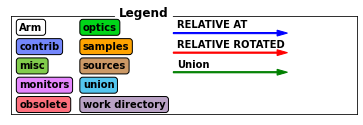

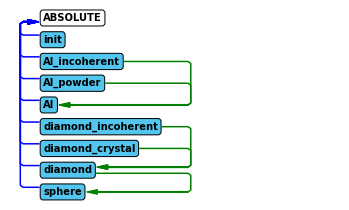

In [2]:
sphere = instrument.add_component("sphere", "Union_sphere")
sphere.radius = 0.01
sphere.material_string = '"diamond"'
sphere.set_AT([0, 0, 1])

instrument.show_diagram()

In [3]:
print(sphere)

COMPONENT sphere = Union_sphere(
  material_string = "diamond", // []
  priority : Required parameter not yet specified
  radius = 0.01 // [m]
)
AT (0, 0, 1) ABSOLUTE


### Geometry priority
Priority is a required parameter that handles how geometries overlap. Any point in space corresponds to one material, so when a point is in two or more geometries, the material with the highest priority is used.

In [4]:
%matplotlib widget
import geometry_example
geometry_example.show()

### Adding am aluminium shell around our diamond sphere

In [5]:
sphere.priority = 10

shell = instrument.add_component("shell", "Union_cylinder")
shell.set_parameters(radius=0.05, yheight=0.12,
                     material_string = '"Al"', priority=3,
                     p_interact=0.2)
shell.set_AT(0, RELATIVE=sphere)

shell_vacuum = instrument.add_component("shell_vacuum", "Union_cylinder")
shell_vacuum.set_parameters(radius=shell.radius - 0.01, yheight=shell.yheight - 0.01,
                            material_string = '"Vacuum"', priority=5)
shell_vacuum.set_AT([0, 0, 0], RELATIVE=shell)

![alt](figures/power_point_figures/Slide5.png)

## Master component
There are four different types of Union components that must be present in an instrument to perform a simulation:

- process components
- make_material component
- geometry components
- master

The *Union_master* component contains the engine that actually performs the simulation. It is the location of the Union master that decides where in the sequence of McStas components the Union system is simulated.

![alt](figures/power_point_figures/Slide4.png)

### Placing the source
Since the master component will perform the simulation in the McStas component sequence, lets place a source before the master.

In [6]:
source = instrument.add_component("source", "Source_div")
source.set_parameters(focus_aw=0.3, focus_ah=0.3,
                      xwidth=0.005, yheight=0.005,
                      flux=1E12)
source.set_AT(-1, RELATIVE=sphere)

source.lambda0 = instrument.add_parameter("wavelength", value=5.0,
                                          comment="Wavelength in [Ang]")
source.dlambda = instrument.add_parameter("wavelength_half_width", value=4.5,
                                          comment="Wavelength half width in [Ang]")

## Place a master
The master performs a full multiple scattering simulation of all geometries defined before it.

It is possible to have several masters in an instrument, the second would simulate the geometries defined between the two masters.

In McStas 3.X it is also necessary to include a Union_init and Union_stop component before/after any Union components. 

In [7]:
master = instrument.add_component("master", "Union_master")
stop = instrument.add_component("stop", "Union_stop")

In [8]:
instrument.show_diagram()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### Visualizing the instrument
The Master component is required to draw the Union system.

In [9]:
instrument.show_instrument(width=800, height=600)

### Example of system simulated with Union components

![alt](figures/cryostat_geometry.png)

## Cryostat tool
McStasScript has a cryostat tool, there is a demo next to the McStas Advanced Design School.

In [15]:
instrument = ms.McStas_instr("cryostat_demo", input_path="run_folder")
instrument.add_component("init", "Union_init")

orange_cryostat = ms.Cryostat("orange", instrument)
orange_cryostat.set_AT([0, 0 ,1])

orange_cryostat.add_layer(inner_radius=70E-3/2, outer_radius=75E-3/2,
                          origin_to_top=200E-3, top_thickness=-1E-3,
                          origin_to_bottom=83E-3, bottom_thickness=5E-3,
                          p_interact=0.2)

orange_cryostat.add_layer(inner_radius=80E-3/2, outer_radius=81E-3/2,
                          origin_to_bottom=90E-3, bottom_thickness=2E-3, 
                          origin_to_top=240E-3, top_thickness=-1E-3,
                          material="Al", p_interact=0.2)

orange_cryostat.add_layer(inner_radius=95E-3/2, outer_radius=99.5E-3/2,
                          origin_to_bottom=93E-3, bottom_thickness=6E-3,
                          origin_to_top=225E-3, top_thickness=9E-3, p_interact=0.2)

orange_cryostat.build(include_master=True)

stop = instrument.add_component("stop", "Union_stop")

### Showing simple cryostat

In [16]:
instrument.show_instrument()

### Parameters common to all geometry components
Some parameters all geometry components share.

| Parameter name   | Description                                             | Default  |
| :---             |    :----                                                | :----    |
| material_string  | String matching chosen material description             |          |
| priority         | Priority of geometry, controlling overlap material      |          |
| visualize        | Select if geometry should be drawn                      |  1       |
| p_interact       | Probability for scattering for any pass through of ray  |  0       |
| focus parameters | Normal focusing parameters, rarely used but available   |          |
| mask_string      | Use of geometry as mask, discussed in next presentation |          |
| mask_mode        | Use of geometry as mask, discussed in next presentation |          |
| number_of_activations | Advanced feature, discussed in next presentation   |  1       |

## Conclusion
- Geometry components are used to describe the geometry of the system
- Geometry components are given properties by assigning a material
- The simulations happens in the master, and simulates all geometries

## Quiz and exercise
It is time for the second exercise that concerns geometry!